# GALAXIES AND QUASARS
We wanto to build a classifier that distinguish between galaxies and quasars given the intensities of the different colours of the signal. First, we do some scatter plot to vizualize the data. To classify, we won't use the colors themselves, but the differences between near colours.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score
from tqdm import tqdm

In [2]:
full = np.loadtxt("../solutions/galaxyquasar.csv", dtype = str, delimiter=',')
full_data = np.delete(full, [0], axis=0)
names = np.delete(full, range(1, len(full[:, 0])), axis=0)
print(names)

[['u' 'g' 'r' 'i' 'z' 'class' 'z1' 'zerr']]


In [3]:
colors_full = np.zeros((len(full_data[:, 0]), 4))
labels = np.array([])
for i in range(len(full_data[:, 0])):
    colors_full[i] = np.array([float(full_data[i, 0]) - float(full_data[i, 1]), float(full_data[i, 1]) - float(full_data[i, 2]), \
                          float(full_data[i, 2]) - float(full_data[i, 3]), float(full_data[i, 3]) - float(full_data[i, 4])])
    if full_data[i, 5] == "GALAXY":
        labels = np.append(labels, 0)
    else:
        labels = np.append(labels, 1)

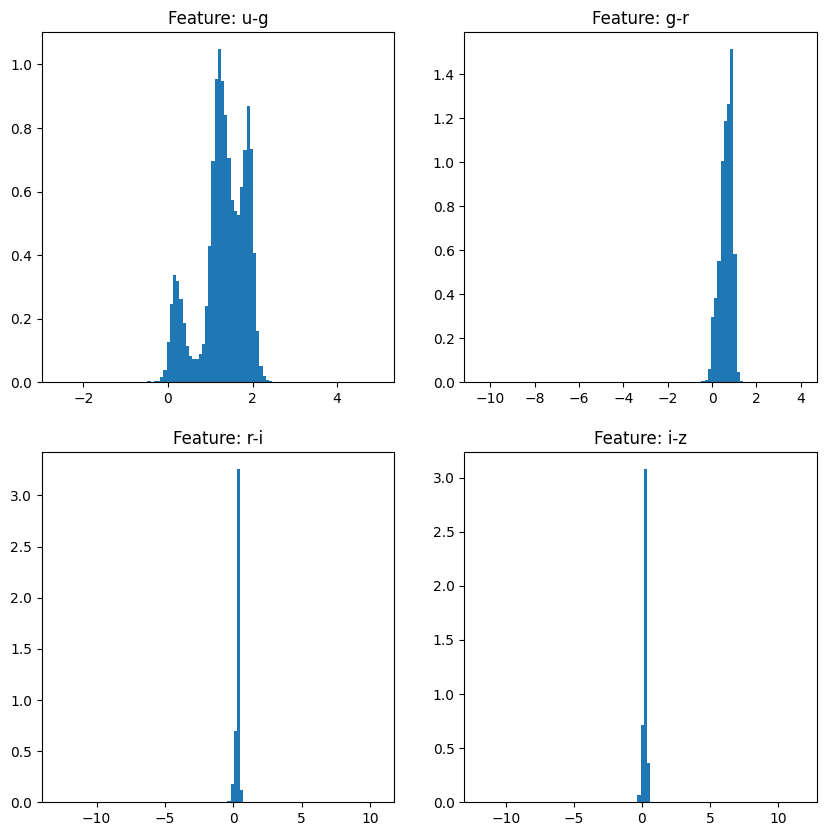

In [4]:
plt.figure(figsize=(10, 10))
title = [r"u-g", r"g-r", r"r-i", r"i-z"]
for i in range(0, 4):
    plt.subplot(2,2,i+1)
    plt.hist(colors_full[:, i], bins = 100, density=True)
    plt.title("Feature: " + title[i])

## Using one the $U-G$ color difference
Now we build some classifiers. To begin we'll use only the first component and we'll use the following algorithms:
1) Gaussian Naive Bayes;
2) Linear Discriminant Analysis;
3) Quadratic Discriminant Analysis;
4) Gaussian Mixture Model classifier for different numbers of components;
5) K-nearest neighbors classifier for different numbers of neighbors.
We compare them plotting the ROC curve and the accuracies.

### Gaussian Naive Bayes, Linear Discriminant Analysis and Quadratic Discriminant Analysis

In [5]:
colors = colors_full[:, 0][:, np.newaxis]

Classifier: GNB; accuracy: 98.070%
Classifier: LDA; accuracy: 98.080%
Classifier: QDA; accuracy: 98.070%


Text(0.5, 1.0, 'ROC curves for some classifiers')

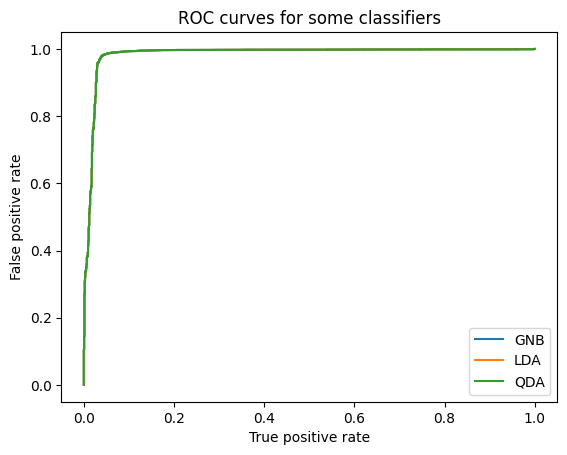

In [6]:
c_train, c_test, l_train, l_test = train_test_split(colors, labels, train_size = 0.8, shuffle=False)
classifiers = [GaussianNB(), LDA(), QDA()]
cl_names = ["GNB", "LDA", "QDA"]
for i in range(len(classifiers)):
    classifiers[i].fit(c_train, l_train)
    l_probs = classifiers[i].predict_proba(c_test)[:, 0]
    l_pred = classifiers[i].predict(c_test)
    fps_cl, tps_cl, _ = roc_curve(l_test[:, np.newaxis], l_probs)
    plt.plot(tps_cl, fps_cl, label=cl_names[i])
    print("Classifier: " + cl_names[i] + "; accuracy: {:.3f}%".format(100*accuracy_score(l_test, l_pred)))

plt.legend()
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title("ROC curves for some classifiers")

### GMM Bayes Classifier

Text(0.5, 1.0, 'ROC curves for GMM classifier with different componennts')

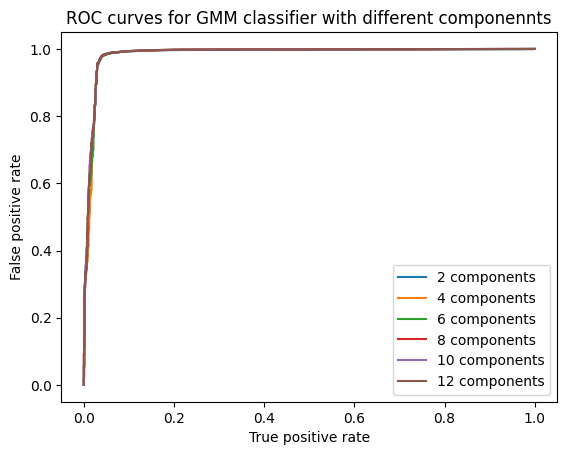

In [7]:
c_train, c_test, l_train, l_test = train_test_split(colors, labels, train_size = 0.8, shuffle=False)

for i in range(2, 13, 2):
    classifier = GMMBayes(i)
    classifier.fit(c_train, l_train)
    l_probs = classifier.predict_proba(c_test)[:, 0]
    fps_cl, tps_cl, _ = roc_curve(l_test[:, np.newaxis], l_probs)
    plt.plot(tps_cl, fps_cl, label="{} components".format(i))

plt.legend()
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title("ROC curves for GMM classifier with different componennts")

We can cross-validate the model on a smaller subset (1000) of the data:

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.76it/s]


(0.9, 1.0)

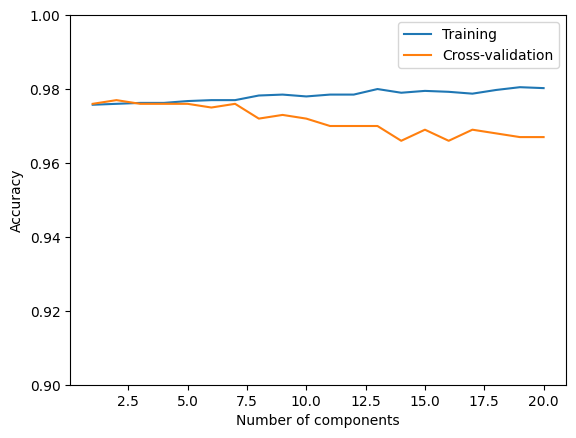

In [8]:
rng = np.random.default_rng(seed=130301)
indices = np.arange(len(colors[:1000, 0]))
rng.shuffle(indices)

K = 5
n_components = 20

train_len = int(len(colors[:1000, 0]) - len(colors[:1000, 0]) / K)
val_len = int(len(colors[:1000, 0]) / K)
acc_tr = np.zeros(K)
acc_te = np.zeros(K)
acc_tr_model = np.zeros(n_components)
acc_te_model = np.zeros(n_components)
for n in tqdm(range(1, n_components + 1)):
    for i in range(0, K):
        test_data = indices[val_len * i : val_len * (i+1)]
        train_data = indices[0:val_len * i]
        train_data = np.append(train_data, indices[val_len * (i+1) : len(colors[:1000, 0])])
        clf = GMMBayes(n)
        clf.fit(colors[train_data], labels[train_data])
        pred_train = clf.predict(colors[train_data])
        pred_test = clf.predict(colors[test_data])
        acc_tr[i] = accuracy_score(labels[train_data], pred_train)
        acc_te[i] = accuracy_score(labels[test_data], pred_test)
    acc_tr_model[n-1], acc_te_model[n-1] = np.mean(acc_tr), np.mean(acc_te)

plt.plot(range(1, n_components + 1), acc_tr_model, label="Training")
plt.plot(range(1, n_components + 1), acc_te_model, label="Cross-validation")
plt.legend()
plt.xlabel("Number of components")
plt.ylabel("Accuracy")
plt.ylim(0.90, 1.00)

The best result is obtained at around 7 components. Now that we have the best hyperparameters, we train the algorithm on the full dataset to get the accuracy:

In [9]:
c_train, c_test, l_train, l_test = train_test_split(colors, labels, train_size = 0.8, shuffle=False)
classifier = GMMBayes(6)
classifier.fit(c_train, l_train)
l_pred = classifier.predict(c_test)
print("Accuracy of the GMM Bayes classifier: {:.3f}%".format(100*(accuracy_score(l_test, l_pred))))

Accuracy of the GMM Bayes classifier: 97.980%


This number is comparable to what we obtained with the Gaussian Naive Bayes classifier. This means that in this case getting more components in general doesn't improve the results.

### K-nearest neighbor classifier:

Text(0.5, 1.0, 'ROC curves for K-nearest neighbor classifier')

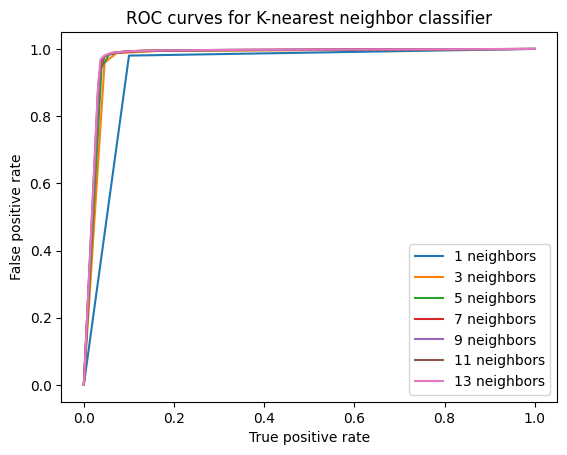

In [10]:
c_train, c_test, l_train, l_test = train_test_split(colors, labels, train_size = 0.8, shuffle=False)

for i in range(1, 15, 2):
    classifier = KNeighborsClassifier(i)
    classifier.fit(c_train, l_train)
    l_probs = classifier.predict_proba(c_test)[:, 0]
    fps_cl, tps_cl, _ = roc_curve(l_test[:, np.newaxis], l_probs)
    plt.plot(tps_cl, fps_cl, label="{} neighbors".format(i))

plt.legend()
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title("ROC curves for K-nearest neighbor classifier")

Also here we cross-validate the number of neighbors:

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.54it/s]


(0.9, 1.0)

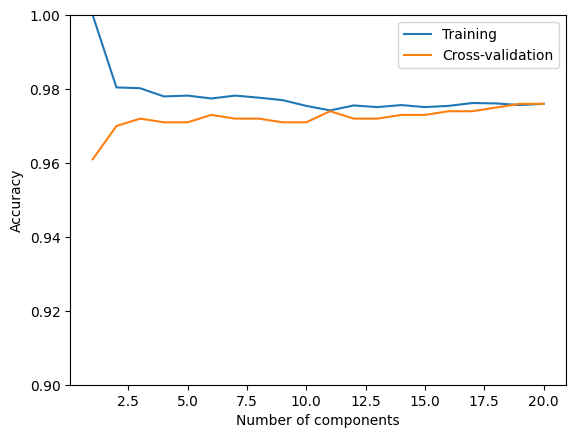

In [11]:
rng = np.random.default_rng(seed=130301)
indices = np.arange(len(colors[:1000, 0]))
rng.shuffle(indices)

K = 10
n_neigh = 20

train_len = int(len(colors[:1000, 0]) - len(colors[:1000, 0]) / K)
val_len = int(len(colors[:1000, 0]) / K)
acc_tr = np.zeros(K)
acc_te = np.zeros(K)
acc_tr_model = np.zeros(n_neigh)
acc_te_model = np.zeros(n_neigh)
for n in tqdm(range(1, n_neigh + 1)):
    for i in range(0, K):
        test_data = indices[val_len * i : val_len * (i+1)]
        train_data = indices[0:val_len * i]
        train_data = np.append(train_data, indices[val_len * (i+1) : len(colors[:1000, 0])])
        clf = KNeighborsClassifier(n)
        clf.fit(colors[train_data], labels[train_data])
        pred_train = clf.predict(colors[train_data])
        pred_test = clf.predict(colors[test_data])
        acc_tr[i] = accuracy_score(labels[train_data], pred_train)
        acc_te[i] = accuracy_score(labels[test_data], pred_test)
    acc_tr_model[n-1], acc_te_model[n-1] = np.mean(acc_tr), np.mean(acc_te)

plt.plot(range(1, n_neigh + 1), acc_tr_model, label="Training")
plt.plot(range(1, n_neigh + 1), acc_te_model, label="Cross-validation")
plt.legend()
plt.xlabel("Number of components")
plt.ylabel("Accuracy")
plt.ylim(0.90, 1.00)

In this case, after three/four neighbors the accuracy doesn't improve. We choose the one with four neighbors as the best model. We now train it on the full dataset.

In [12]:
c_train, c_test, l_train, l_test = train_test_split(colors, labels, train_size = 0.8, shuffle=False)
classifier = KNeighborsClassifier(6)
classifier.fit(c_train, l_train)
l_pred = classifier.predict(c_test)
print("Accuracy of the K-nearest neighbors classifier: {:.3f}%".format(100*(accuracy_score(l_test, l_pred))))

Accuracy of the K-nearest neighbors classifier: 97.980%


## All the feature
We now repeat what we did but using all the features.
### Gaussian Naive Bayes, Linear Discriminant Analysis and Quadratic Discriminant Analysis

In [13]:
colors = colors_full

Classifier: GNB; accuracy: 97.240%
Classifier: LDA; accuracy: 98.140%
Classifier: QDA; accuracy: 98.090%


Text(0.5, 1.0, 'ROC curves for some classifiers')

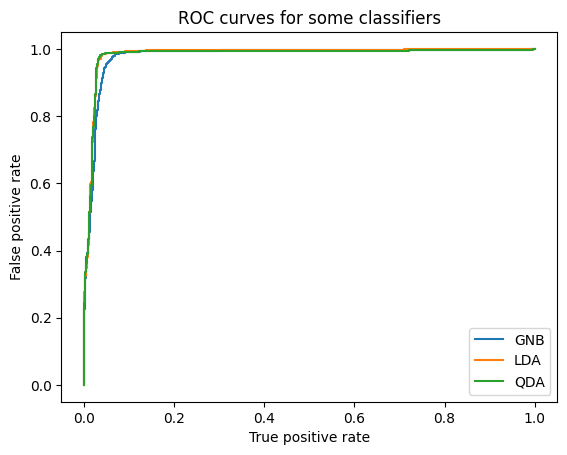

In [14]:
c_train, c_test, l_train, l_test = train_test_split(colors, labels, train_size = 0.8, shuffle=False)
classifiers = [GaussianNB(), LDA(), QDA()]
cl_names = ["GNB", "LDA", "QDA"]
for i in range(len(classifiers)):
    classifiers[i].fit(c_train, l_train)
    l_probs = classifiers[i].predict_proba(c_test)[:, 0]
    l_pred = classifiers[i].predict(c_test)
    fps_cl, tps_cl, _ = roc_curve(l_test[:, np.newaxis], l_probs)
    plt.plot(tps_cl, fps_cl, label=cl_names[i])
    print("Classifier: " + cl_names[i] + "; accuracy: {:.3f}%".format(100*accuracy_score(l_test, l_pred)))

plt.legend()
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title("ROC curves for some classifiers")

We see that the accuracies of the algorithms basically don't improve using all the components. This suggests that it is indeed the first feature to contain most of the information about the underlying population. 
### GMM Bayes Classifier

Text(0.5, 1.0, 'ROC curves for GMM classifier with different componennts')

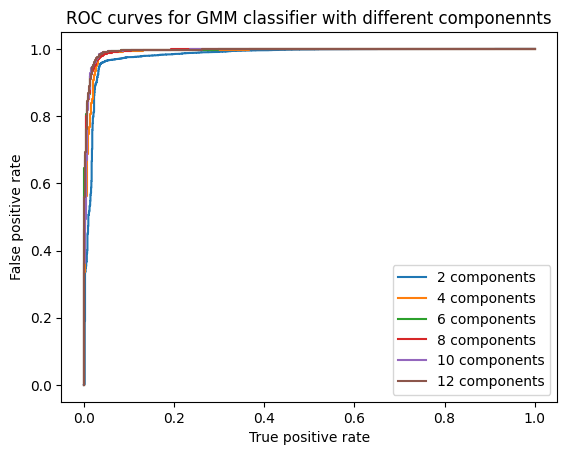

In [15]:
c_train, c_test, l_train, l_test = train_test_split(colors, labels, train_size = 0.8, shuffle=False)

for i in range(2, 13, 2):
    classifier = GMMBayes(i)
    classifier.fit(c_train, l_train)
    l_probs = classifier.predict_proba(c_test)[:, 0]
    fps_cl, tps_cl, _ = roc_curve(l_test[:, np.newaxis], l_probs)
    plt.plot(tps_cl, fps_cl, label="{} components".format(i))

plt.legend()
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title("ROC curves for GMM classifier with different componennts")

We can cross-validate the model on a smaller subset of the data:

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.49it/s]


(0.9, 1.0)

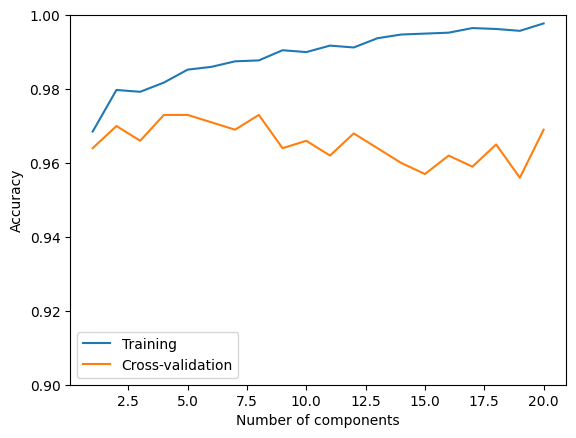

In [16]:
rng = np.random.default_rng(seed=130301)
indices = np.arange(len(colors[:1000, 0]))
rng.shuffle(indices)

K = 5
n_components = 20

train_len = int(len(colors[:1000, 0]) - len(colors[:1000, 0]) / K)
val_len = int(len(colors[:1000, 0]) / K)
acc_tr = np.zeros(K)
acc_te = np.zeros(K)
acc_tr_model = np.zeros(n_components)
acc_te_model = np.zeros(n_components)
for n in tqdm(range(1, n_components + 1)):
    for i in range(0, K):
        test_data = indices[val_len * i : val_len * (i+1)]
        train_data = indices[0:val_len * i]
        train_data = np.append(train_data, indices[val_len * (i+1) : len(colors[:1000, 0])])
        clf = GMMBayes(n)
        clf.fit(colors[train_data], labels[train_data])
        pred_train = clf.predict(colors[train_data])
        pred_test = clf.predict(colors[test_data])
        acc_tr[i] = accuracy_score(labels[train_data], pred_train)
        acc_te[i] = accuracy_score(labels[test_data], pred_test)
    acc_tr_model[n-1], acc_te_model[n-1] = np.mean(acc_tr), np.mean(acc_te)

plt.plot(range(1, n_components + 1), acc_tr_model, label="Training")
plt.plot(range(1, n_components + 1), acc_te_model, label="Cross-validation")
plt.legend()
plt.xlabel("Number of components")
plt.ylabel("Accuracy")
plt.ylim(0.90, 1.00)

Here we can see some overfitting when the number of components gets higher. We see that the performance are quite similar when the components are between 4 and 6. We choose six components, and train the algorithm on the full dataset to see the accuracy:

In [17]:
c_train, c_test, l_train, l_test = train_test_split(colors, labels, train_size = 0.8, shuffle=False)
classifier = GMMBayes(6)
classifier.fit(c_train, l_train)
l_pred = classifier.predict(c_test)
print("Accuracy of the GMM Bayes classifier: {:.3f}%".format(100*(accuracy_score(l_test, l_pred))))

Accuracy of the GMM Bayes classifier: 98.350%


Slightly better than with one feature. Probably, with more features having more than one components helps the classification.

### K-nearest neighbor classifier:

Text(0.5, 1.0, 'ROC curves for K-nearest neighbor classifier')

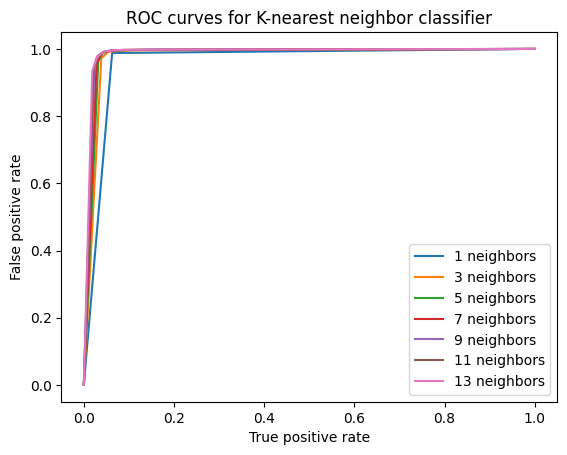

In [18]:
c_train, c_test, l_train, l_test = train_test_split(colors, labels, train_size = 0.8, shuffle=False)

for i in range(1, 15, 2):
    classifier = KNeighborsClassifier(i)
    classifier.fit(c_train, l_train)
    l_probs = classifier.predict_proba(c_test)[:, 0]
    fps_cl, tps_cl, _ = roc_curve(l_test[:, np.newaxis], l_probs)
    plt.plot(tps_cl, fps_cl, label="{} neighbors".format(i))

plt.legend()
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title("ROC curves for K-nearest neighbor classifier")

Also here we cross-validate the number of neighbors:

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.28it/s]


(0.9, 1.0)

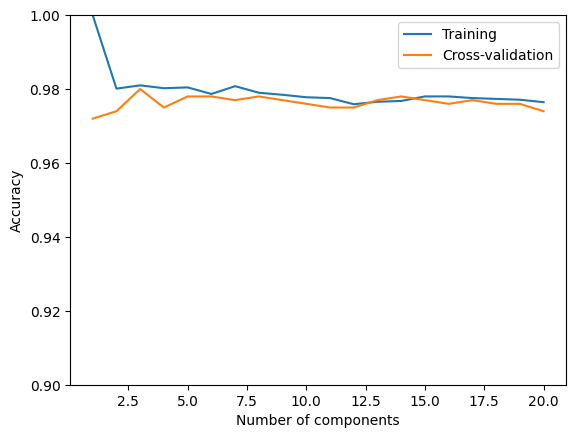

In [19]:
rng = np.random.default_rng(seed=130301)
indices = np.arange(len(colors[:1000, 0]))
rng.shuffle(indices)

K = 10
n_neigh = 20

train_len = int(len(colors[:1000, 0]) - len(colors[:1000, 0]) / K)
val_len = int(len(colors[:1000, 0]) / K)
acc_tr = np.zeros(K)
acc_te = np.zeros(K)
acc_tr_model = np.zeros(n_neigh)
acc_te_model = np.zeros(n_neigh)
for n in tqdm(range(1, n_neigh + 1)):
    for i in range(0, K):
        test_data = indices[val_len * i : val_len * (i+1)]
        train_data = indices[0:val_len * i]
        train_data = np.append(train_data, indices[val_len * (i+1) : len(colors[:1000, 0])])
        clf = KNeighborsClassifier(n)
        clf.fit(colors[train_data], labels[train_data])
        pred_train = clf.predict(colors[train_data])
        pred_test = clf.predict(colors[test_data])
        acc_tr[i] = accuracy_score(labels[train_data], pred_train)
        acc_te[i] = accuracy_score(labels[test_data], pred_test)
    acc_tr_model[n-1], acc_te_model[n-1] = np.mean(acc_tr), np.mean(acc_te)

plt.plot(range(1, n_neigh + 1), acc_tr_model, label="Training")
plt.plot(range(1, n_neigh + 1), acc_te_model, label="Cross-validation")
plt.legend()
plt.xlabel("Number of components")
plt.ylabel("Accuracy")
plt.ylim(0.90, 1.00)

Also in this case, after three neighbors the accuracy doesn't improve, so we choose it as the best model. We now train on the full dataset.

In [20]:
c_train, c_test, l_train, l_test = train_test_split(colors, labels, train_size = 0.8, shuffle=False)
classifier = KNeighborsClassifier(3)
classifier.fit(c_train, l_train)
l_pred = classifier.predict(c_test)
print("Accuracy of the K-nearest neighbors classifier: {:.3f}%".format(100*(accuracy_score(l_test, l_pred))))

Accuracy of the K-nearest neighbors classifier: 98.480%


Also in this case the accuracy improves slightly if we consider all the features.